In [3]:
import numpy as np
A = np.array([
    [1, 0, 2, 2, 0],
    [3, 4, 0, 5, 0],
    [6, 0, 7, 8, 9],
    [0, 0, 10, 11, 0],
    [0, 0, 0, 0, 12]
])
print(A)

[[ 1  0  2  2  0]
 [ 3  4  0  5  0]
 [ 6  0  7  8  9]
 [ 0  0 10 11  0]
 [ 0  0  0  0 12]]


# the COO (Coordinate) format

In [4]:
from scipy.sparse import coo_matrix

A_coo = coo_matrix(A)

print(A_coo.row)
print(A_coo.col)
print(A_coo.data)

[0 0 0 1 1 1 2 2 2 2 3 3 4]
[0 2 3 0 1 3 0 2 3 4 2 3 4]
[ 1  2  2  3  4  5  6  7  8  9 10 11 12]


![COO](https://upload-images.jianshu.io/upload_images/9637742-3e4d9dabb304334a.png?imageMogr2/auto-orient/strip|imageView2/2/w/700/format/webp)
在生成稀疏矩阵的过程中，最常使用的是Scipy中的coo格式。
该格式非常简单
我们只需要提供**the row, column and data arrays**来创建coo矩阵。
优点：can **repeat indice**
在矩阵创建过程中，与同一个矩阵条目关联的所有数据条目都只是相加。这是一个非常自然的操作，简化了我们需要创建稀疏矩阵的许多情况。

然而，coo不是典型矩阵操作的合适格式。此外，就存储需求而言，它还不是最佳的。

## The CSR (Compressed Sparse Row) Format

In [5]:
A_csr = A_coo.tocsr()

print(A_csr.data)
print(A_csr.indices)
print(A_csr.indptr)

[ 1  2  2  3  4  5  6  7  8  9 10 11 12]
[0 2 3 0 1 3 0 2 3 4 2 3 4]
[ 0  3  6 10 12 13]


![CSR](https://upload-images.jianshu.io/upload_images/9637742-1b1bd3ab8a9c57b6.png?imageMogr2/auto-orient/strip|imageView2/2/w/702/format/webp)

* The ``indptr`` array is always 1 element larger than the number of rows(行数) in the matrix.
* The last entry of the ``indptr`` array is the total number of nonzero elements(非零元素的个数).

## CSR Matrix-vector products

In [6]:
import numba

@numba.jit(nopython=True, parallel=True)
def csr_matvec(data, indices, indptr, shape, x):
    """Evaluates the matrix-vector product with a CSR matrix."""
    # Get the rows and columns

    m, n = shape

    y = np.zeros(m, dtype=np.float64)

    for row_index in numba.prange(m):
        col_start = indptr[row_index]
        col_end = indptr[row_index + 1]
        for col_index in range(col_start, col_end):
            y[row_index] += data[col_index] * x[indices[col_index]]

    return y


In [8]:
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""

    nelements = 5 * N**2 - 16 * N + 16

    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)

    f = np.empty(N * N, dtype=np.float64)

    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1

            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i

                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1

                count += 5

    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [9]:
N = 1000

A, _ = discretise_poisson(N)

# Generate a random vector
rand = np.random.RandomState(0)
x = rand.randn(N * N)

y = csr_matvec(A.data, A.indices, A.indptr, A.shape, x)

# Compare with the Scipy sparse matrix multiplication

y_exact = A @ x
rel_error = np.linalg.norm(y - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


In [10]:
# Our implementation
%timeit y = csr_matvec(A.data, A.indices, A.indptr, A.shape, x)

# The default Scipy implementation
%timeit y = A @ x

3.52 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.73 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
import numpy as np
import numba

sigma = .1

@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""

    n = len(sources)
    m = len(targets)
    print(m)
    print(n)

    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

In [12]:
npoints = 400
nsources = 50

plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)

# We are picking random sources

sources = rand.rand(nsources, 3)

480000
50


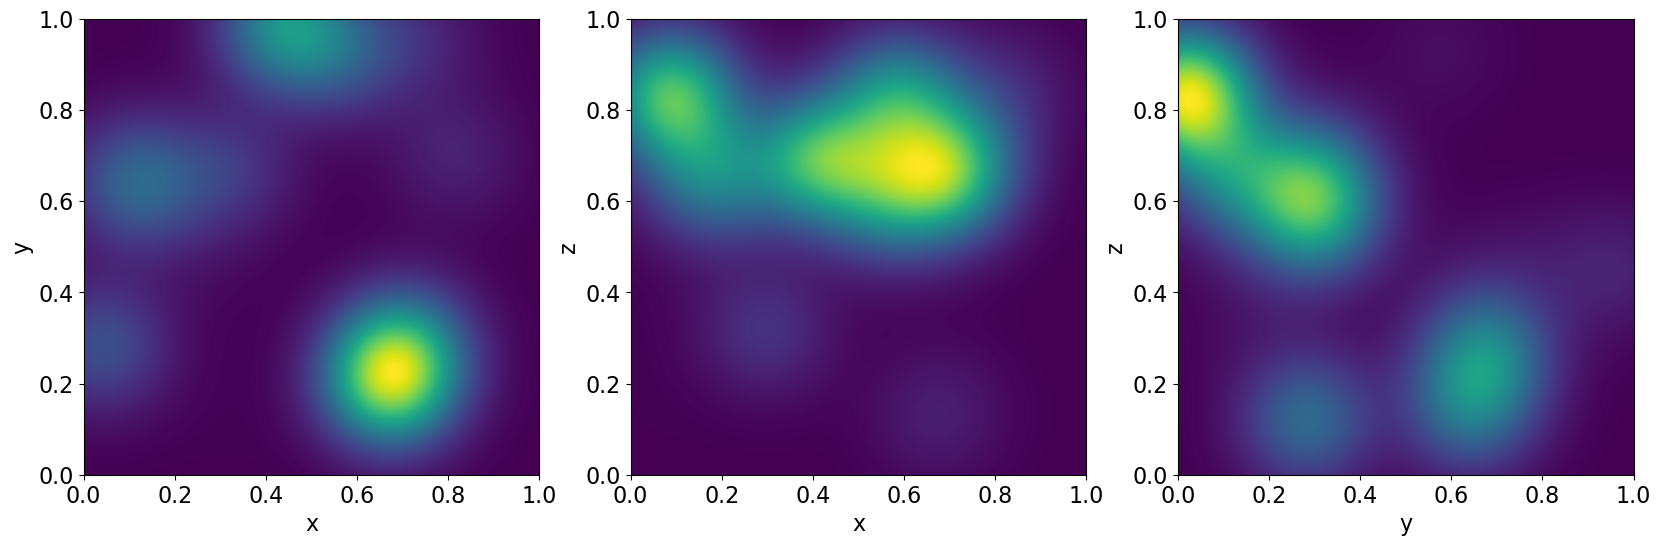

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.size"] = 16

result = np.zeros(len(targets), dtype=np.float64)

weights = rand.rand(len(sources))

rbf_evaluation(sources, targets, weights, result)

def visualize(result, npoints):
    """A helper function for visualization"""

    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(1, 3, 1)
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')



visualize(result, npoints)